# Lecture 7: Metric learning


We provide a colab with training, inference, and clustering code using CNNs trained with metric learning approaches.

## Notebook steps:
1. Train a CNN with the triplet loss
2. Plot the clustering results of the validation set
3. Train a CNN with the InfoNCE loss
4. Perform clustering of the validation set

In [ ]:
!pip install torch
!pip install torchcodec
!pip install datasets[audio]==3
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install torch-audiomentations

In [ ]:
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import umap
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, Resample
from torch_audiomentations import (
    Compose,
    Gain,
    PolarityInversion,
    AddBackgroundNoise,
    AddColoredNoise,
    BandStopFilter,
    ApplyImpulseResponse,
    PitchShift,
    LowPassFilter,
)
from tqdm import tqdm

device = "cpu"  # Configure depending on the runtime

In [ ]:
# Use Datasets to load GTZAN
ds = load_dataset("sanchit-gandhi/gtzan", split="train")

# make random train/val splits
splits = ds.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]

In [ ]:
class GTZANDataset(Dataset):
    "Multiview GTZAN Genre dataset based on HuggingFace Datasets"
    def __init__(self, dataset, device):
        self.orig_sample_rate = 32000
        self.sample_rate = 16000
        self.audio_duration = 3  # Segment durations
        self.max_separation = 1  # maximum separation between views
        self.device =  device

        self.dataset = dataset

        self.n_samples = self.sample_rate * self.audio_duration

        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)

        self.keep_genres = set(["rock", "classical", "jazz", "disco"])

        # Load audio and labels
        self.audio = {}
        self.natural_labels = {}
        for track in tqdm(self.dataset, desc="Loading audio"):
            tid = Path(track["file"]).stem
            genre = tid.split(".")[0]

            if genre not in self.keep_genres:
                continue

            x = track["audio"]["array"]
            x = torch.tensor(x)
            sr = track["audio"]["sampling_rate"]

            if sr != self.sample_rate:
              if sr != self.orig_sample_rate:
                self.resample = Resample(orig_freq=sr, new_freq=self.sample_rate)
                self.orig_sample_rate = sr

              x = self.resample(x.float())

            self.audio[tid] = x.to(self.device)
            self.natural_labels[tid] = genre

        self.tids = list(self.audio.keys())

        # One hot encode labels
        natural_labels = np.array(list(self.natural_labels.values())).reshape(-1, 1)
        ohe = OneHotEncoder()
        one_hot_labels = ohe.fit_transform(natural_labels).toarray()
        self.labels = {k: v for k, v in zip(self.tids, one_hot_labels)}

    def __len__(self):
        return len(self.tids)

    def get_start_end_indices(self, min, max):
        start = random.randint(min, max - self.n_samples)
        end = start + self.n_samples
        return start, end

    def __getitem__(self, idx):
        tid = self.tids[idx]
        audio_full = self.audio[tid]
        labels = self.labels[tid]
        natural_labels = self.natural_labels[tid]

        # get the first view from a random position in the track.
        min_pos, max_pos = 0, audio_full.shape[0]

        start, end = self.get_start_end_indices(min_pos, max_pos)
        view_1 = audio_full[start:end]

        # the second view should start within a window of n seconds from  the first view.
        min_pos = max(0, min_pos - self.max_separation * self.sample_rate)
        max_pos = min(audio_full.shape[0], max_pos + self.max_separation * self.sample_rate)

        start, end = self.get_start_end_indices(min_pos, max_pos)
        view_2 = audio_full[start:end]


        return {"view_1": view_1, "view_2": view_2, "labels": labels, "natural_labels": natural_labels}

train_dataset = GTZANDataset(train_ds, device=device)
val_dataset = GTZANDataset(val_ds, device=device)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading audio: 100%|██████████| 200/200 [00:06<00:00, 29.27it/s]


### Step 2: Define the CNN model
We will define a simple CNN architecture suitable for music autotagging.


In [ ]:
# Feature extractor. Using mel-spectrogram

class FeatureExtractor(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.melspectrogram = MelSpectrogram(**kwargs)

    def forward(self, x):
        x = self.melspectrogram(x)
        x = torch.log10(1 + 1000 * x)  # Log-compression
        return x

class AugmentationChain(nn.Module):
    """Add a number of audio augmentaitons with probability p."""

    p = 0.75
    sr = 16000
    def __init__(self, **kwargs):
        super().__init__()
        self.chain = Compose(
            transforms=[
                Gain(p=self.p, output_type='tensor'),
                BandStopFilter(sample_rate=self.sr, p=self.p, output_type='tensor'),
                PitchShift(p=self.p, sample_rate=self.sr, output_type='tensor'),
                AddColoredNoise(p=self.p, output_type='tensor'),
                LowPassFilter(p=self.p, sample_rate=self.sr, min_cutoff_freq=400, output_type='tensor',),
            ]
            , output_type='tensor'
        )

    def forward(self, audio):
        return self.chain(audio.unsqueeze(1)).squeeze(1)

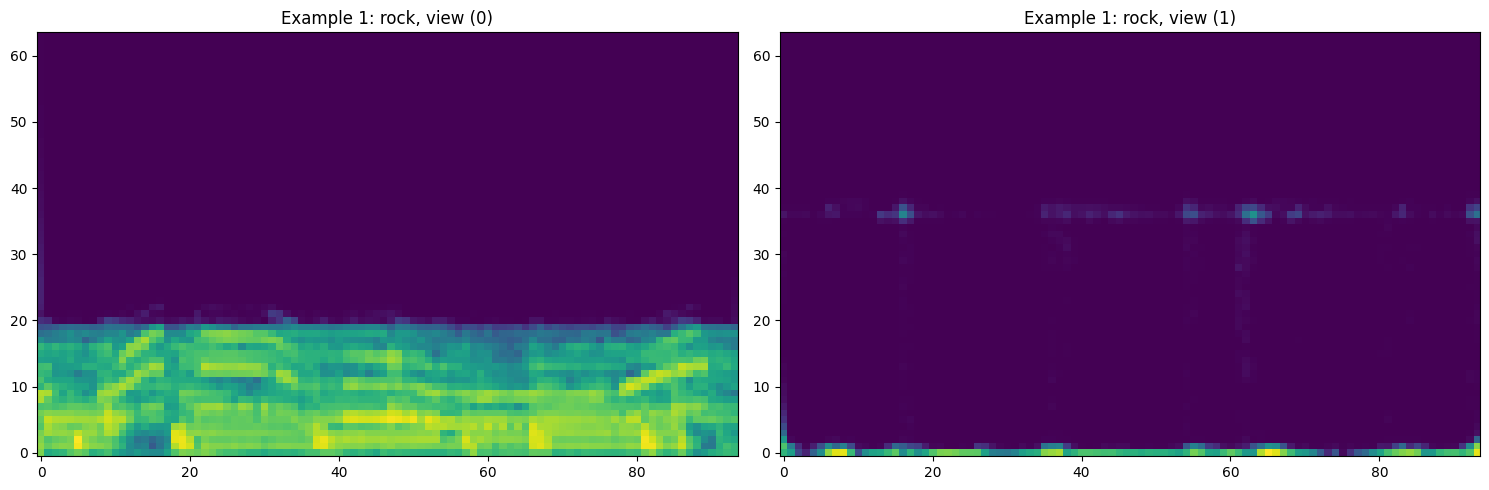

In [ ]:
feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024).to(device)
augmentation_chain = AugmentationChain().to(device)

# Fetch a batch of data
batch = next(iter(val_loader))
mel_specs_1 = feature_extractor(augmentation_chain(batch["view_1"])).cpu().numpy()
mel_specs_2 = feature_extractor(augmentation_chain(batch["view_2"])).cpu().detach().numpy()

# Visualize the first three mel-spectrograms in the batch
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, mels in enumerate([mel_specs_1, mel_specs_2]):
    axes[i].imshow(mels[0], aspect="auto", origin="lower")
    axes[i].set_title(f"Example {0+1}: {batch['natural_labels'][0]}, view ({i})")
plt.tight_layout()
plt.show()

In [ ]:
n_classes = len(set(val_dataset.natural_labels.values()))

batch = next(iter(val_loader))
mels = feature_extractor(batch["view_1"])

print("Mel-spectrogram shape:", mels.shape)
print("Number of classes:", n_classes)

Mel-spectrogram shape: torch.Size([79, 64, 94])
Number of classes: 4


In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        kernel_size: int = 3,
        pooling_size: int = 4,
        dense_size: int = 64,
        output_size: int = 10,
    ):
        super().__init__()
        self.dense_size = dense_size
        self.conv1 = nn.Conv2d(
            1, dense_size // 4, kernel_size=kernel_size, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            dense_size // 4, dense_size // 2, kernel_size=kernel_size, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            dense_size // 2, dense_size, kernel_size=kernel_size, stride=1, padding=1
        )

        self.bn1 = nn.BatchNorm2d(dense_size // 4)
        self.bn2 = nn.BatchNorm2d(dense_size // 2)
        self.bn3 = nn.BatchNorm2d(dense_size)

        self.pool = nn.MaxPool2d(kernel_size=pooling_size, stride=pooling_size)
        self.fc1 = nn.Linear(dense_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.bn3(self.pool(F.relu(self.conv3(x))))

        x = x.view(-1, self.dense_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Step 3: Train the models
Set up the training loop with loss functions and optimizers.


In [ ]:
# Training loop
def train(
    model,
    loss_fn,
    n_epochs=3,
    lr=0.001,
    device="cuda",
    augment=True,
    batch_size=64,
):
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(n_epochs):
        # Training loop
        model.train()
        total_loss = 0
        for i, batch in enumerate(train_loader):
            x1 = batch["view_1"].to(device)
            x2 = batch["view_2"].to(device)

            if augment:
              x1 = augmentation_chain(x1)
              x2 = augmentation_chain(x2)

            x1 = feature_extractor(x1)
            x2 = feature_extractor(x2)

            # Forward step for both augmentations
            z1 = model(x1)
            z2 = model(x2)
            loss = loss_fn(z1, z2)
            total_loss += loss.item()

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = total_loss / len(train_loader)

        # Validation loop (still using cross-entropy for evaluation)
        model.eval()
        total_val_loss = 0

        for i, batch in enumerate(val_loader):
            x1 = batch["view_1"].to(device)
            x2 = batch["view_2"].to(device)

            if augment:
                x1 = augmentation_chain(x1)
                x2 = augmentation_chain(x2)

            x1 = feature_extractor(x1)
            x2 = feature_extractor(x2)

            # Forward step for both augmentations
            z1 = model(x1)
            z2 = model(x2)
            loss = loss_fn(z1, z2)

            total_val_loss += loss.item()

        val_loss = total_val_loss / len(val_loader)

        print(
            f"Epoch [{epoch + 1}/{n_epochs}], "
            + f"Train loss: {train_loss:.4f}, "
            + f"Val loss: {val_loss:.4f}"
        )

In [ ]:
def triplet_loss(anchor, positive, margin=1.0):
    # Pick a random negative from the batch (next sample)
    negative = torch.roll(positive, 1, dims=0)

    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)

    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

In [ ]:
def InfoNCE(z_1, z_2, temp=0.5):
    # Normalize the embeddings
    z_1 = F.normalize(z_1, dim=1)
    z_2 = F.normalize(z_2, dim=1)

    # Similarity matrices
    sim_12 = torch.matmul(z_1, z_2.T)  # z1 as anchor, z2 as candidates
    sim_21 = torch.matmul(z_2, z_1.T)  # z2 as anchor, z1 as candidates

    # Labels: each sample i should match its own pair i
    labels = torch.arange(sim_12.size(0)).to(sim_12.device)

    # InfoNCE losses (both directions)
    loss_12 = F.cross_entropy(sim_12 / temp, labels)
    loss_21 = F.cross_entropy(sim_21 / temp, labels)

    # Symmetric SimCLR loss
    return 0.5 * (loss_12 + loss_21)

In [ ]:
# Extract embeddings for the validation set
def plot_val_embeddings(model, device="cuda"):
    model.eval()
    embeddings = []
    natural_labels = []

    model.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        for key, audio in val_dataset.audio.items():
            n_samples = val_dataset.n_samples
            cut = audio.shape[0] % n_samples
            audio = audio[: -cut]
            batch = audio.view(-1, n_samples)
            x = feature_extractor(audio).unsqueeze(0)
            z = model(x)
            z = torch.mean(z, dim=0)

            embeddings.append(z.cpu().numpy())
            natural_labels.append(val_dataset.natural_labels[key])

    embeddings = np.stack(embeddings)
    natural_labels = np.array(natural_labels)

    # Perform UMAP
    reducer = umap.UMAP(n_components=2)
    umap_embeddings = reducer.fit_transform(embeddings)

    # Create UMAP plot
    unique_labels, label_indices = np.unique(natural_labels, return_inverse=True)

    cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        umap_embeddings[:, 0],
        umap_embeddings[:, 1],
        c=label_indices,
        cmap=cmap,
    )

    handles, _ = scatter.legend_elements(prop="colors", num=len(unique_labels))
    plt.legend(handles, unique_labels, title="Labels")

    plt.title("UMAP of Audio Embeddings")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

CNN Trainable parameters: 31840


/tmp/ipython-input-2105884685.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))


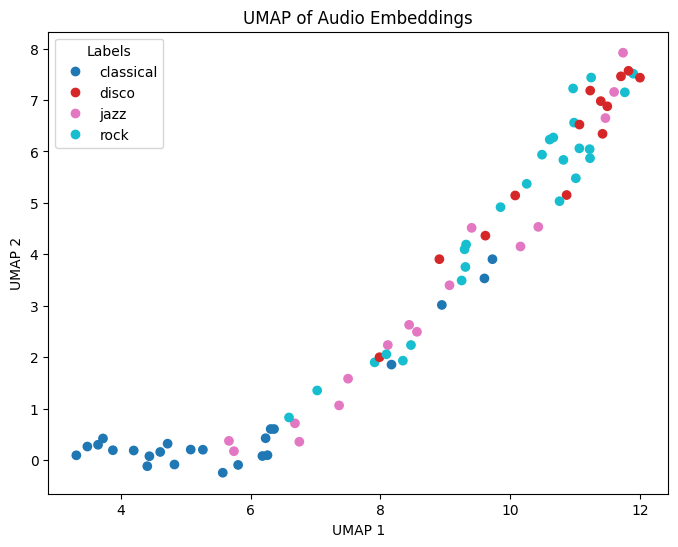

In [ ]:
cnn = CNN(dense_size=64, output_size=64).to(device)

num_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"CNN Trainable parameters: {num_params}")

plot_val_embeddings(cnn, device=device)


Training model with the triplet loss
Epoch [1/20], Train loss: 1.3387, Val loss: 0.9413
Epoch [2/20], Train loss: 1.0890, Val loss: 0.9889
Epoch [3/20], Train loss: 1.0497, Val loss: 1.2039
Epoch [4/20], Train loss: 0.9429, Val loss: 0.9313
Epoch [5/20], Train loss: 0.8769, Val loss: 0.7042
Epoch [6/20], Train loss: 0.8368, Val loss: 0.9405
Epoch [7/20], Train loss: 0.8410, Val loss: 0.7675
Epoch [8/20], Train loss: 0.8852, Val loss: 0.7098
Epoch [9/20], Train loss: 0.8406, Val loss: 0.6712
Epoch [10/20], Train loss: 0.7817, Val loss: 0.7564
Epoch [11/20], Train loss: 0.7295, Val loss: 0.9640
Epoch [12/20], Train loss: 0.7916, Val loss: 0.8331
Epoch [13/20], Train loss: 0.8640, Val loss: 0.7743
Epoch [14/20], Train loss: 0.7960, Val loss: 0.8694
Epoch [15/20], Train loss: 0.8159, Val loss: 0.7585
Epoch [16/20], Train loss: 0.8237, Val loss: 0.7192
Epoch [17/20], Train loss: 0.7969, Val loss: 0.6717
Epoch [18/20], Train loss: 0.7971, Val loss: 0.8767
Epoch [19/20], Train loss: 0.7887, 

/tmp/ipython-input-2105884685.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))


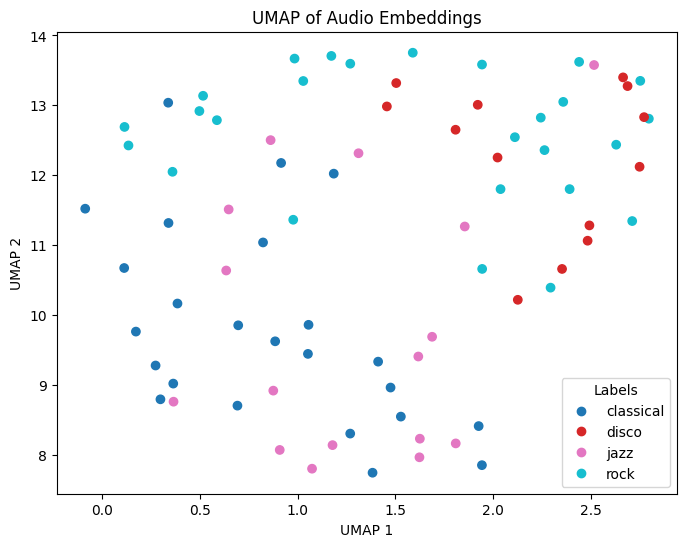

In [ ]:
cnn = CNN(dense_size=64, output_size=64).to(device)

print("\nTraining model with the triplet loss")
train(cnn, triplet_loss, n_epochs=20, device=device, batch_size=64)
plot_val_embeddings(cnn, device=device)


Training model with the InfoNCE loss
Epoch [1/20], Train loss: 4.0780, Val loss: 3.3561
Epoch [2/20], Train loss: 4.0892, Val loss: 3.3291
Epoch [3/20], Train loss: 4.0593, Val loss: 3.2332
Epoch [4/20], Train loss: 4.0194, Val loss: 3.2908
Epoch [5/20], Train loss: 3.9619, Val loss: 3.1825
Epoch [6/20], Train loss: 3.9575, Val loss: 3.3654
Epoch [7/20], Train loss: 3.8742, Val loss: 3.1955
Epoch [8/20], Train loss: 3.8757, Val loss: 3.1564
Epoch [9/20], Train loss: 3.7563, Val loss: 3.0947
Epoch [10/20], Train loss: 3.7239, Val loss: 3.0084
Epoch [11/20], Train loss: 3.7022, Val loss: 3.1002
Epoch [12/20], Train loss: 3.7186, Val loss: 3.0663
Epoch [13/20], Train loss: 3.6784, Val loss: 3.0354
Epoch [14/20], Train loss: 3.7239, Val loss: 3.0627
Epoch [15/20], Train loss: 3.6585, Val loss: 3.0374
Epoch [16/20], Train loss: 3.6471, Val loss: 2.9378
Epoch [17/20], Train loss: 3.6058, Val loss: 2.9445
Epoch [18/20], Train loss: 3.6798, Val loss: 2.8184
Epoch [19/20], Train loss: 3.6216, 

/tmp/ipython-input-2105884685.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab10", len(unique_labels))


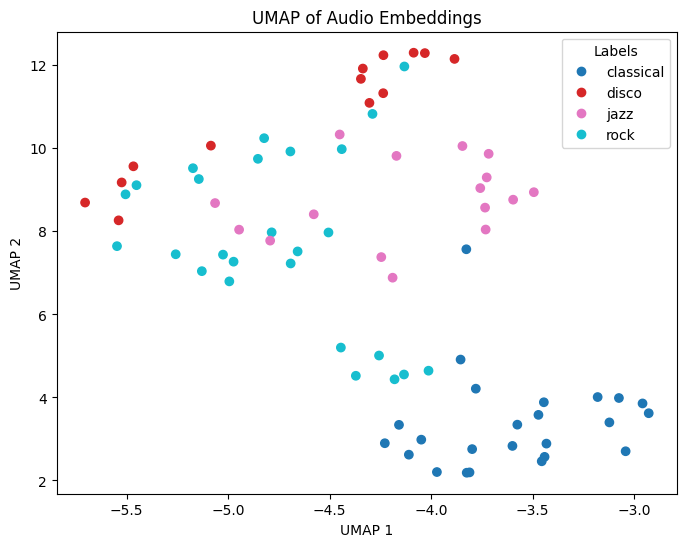

In [ ]:
cnn = CNN(dense_size=64, output_size=64).to(device)

print("\nTraining model with the InfoNCE loss")
train(cnn, InfoNCE, n_epochs=20, device=device, batch_size=64)
plot_val_embeddings(cnn, device=device)